# Ensemble evaluation

In this notebook, our own model prediction performance is evaluated. This includes comparisons with GRACE, WaterGAP, and other reconstructions.

In [1]:
from typing import Literal

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from dask.diagnostics import ProgressBar
from matplotlib_inline.backend_inline import set_matplotlib_formats

import deepwaters  # noqa
from deepwaters import metrics
from deepwaters.preprocessing import calculate_grace_anomaly
from deepwaters.regions import basins
from deepwaters.utils import ROOT_DIR
from deepwaters.visualization import plot_basinwise_map

In [2]:
sns.set_style("whitegrid")
# plt.tight_layout() per default
mpl.rcParams["figure.autolayout"] = True
# Higher figure resolution
set_matplotlib_formats("retina")

# Register dask progress bar
ProgressBar(minimum=5).register()

Open model predictions:

In [3]:
STAGE: Literal["best", "latest"] = "latest"
INPUT: Literal["nogap", "gap"] = "gap"

# Load and combine all test and train predictions
pred_dir = ROOT_DIR / "models/predictions/global"

folds = xr.open_zarr(pred_dir / f"ensemble_alltrain_{INPUT}_lnll_10folds.zarr")
# Use only best/latest predictions
stage_vars = [dvar for dvar in folds.data_vars if dvar.endswith(STAGE)]
folds = folds[stage_vars]

Split in predictions and uncertainty:

In [4]:
pred_vars = [name for name in folds.data_vars if name.split("_")[0] == "pred"]
uncert_vars = [name for name in folds.data_vars if name.split("_")[0] == "uncertainty"]
print(f"{pred_vars = }")
print(f"{uncert_vars = }")

pred_vars = ['pred_4hp19doq_latest', 'pred_b3gt7j7z_latest', 'pred_buhc4fdc_latest', 'pred_evqc2hjf_latest', 'pred_hv8me28j_latest', 'pred_j523uln8_latest', 'pred_lzxuokpb_latest', 'pred_o6xwtzza_latest', 'pred_sslgaubm_latest', 'pred_vjqt3ytm_latest']
uncert_vars = ['uncertainty_4hp19doq_latest', 'uncertainty_b3gt7j7z_latest', 'uncertainty_buhc4fdc_latest', 'uncertainty_evqc2hjf_latest', 'uncertainty_hv8me28j_latest', 'uncertainty_j523uln8_latest', 'uncertainty_lzxuokpb_latest', 'uncertainty_o6xwtzza_latest', 'uncertainty_sslgaubm_latest', 'uncertainty_vjqt3ytm_latest']


In [5]:
# Split in prediction and uncertainty datasets
pred_folds = folds[pred_vars]
scale_folds = folds[uncert_vars]

# Remove pred / uncertainty suffix from data variable names
pred_vars_renamer = {name: name.split("_")[1] for name in pred_vars}
uncert_vars_renamer = {name: name.split("_")[1] for name in uncert_vars}

pred_folds = pred_folds.rename_vars(pred_vars_renamer)
scale_folds = scale_folds.rename_vars(uncert_vars_renamer)

assert list(pred_folds.data_vars) == list(scale_folds.data_vars)

fold_vars = list(pred_folds.data_vars)

print(f"{fold_vars = }")

fold_vars = ['4hp19doq', 'b3gt7j7z', 'buhc4fdc', 'evqc2hjf', 'hv8me28j', 'j523uln8', 'lzxuokpb', 'o6xwtzza', 'sslgaubm', 'vjqt3ytm']


In [6]:
folds_verbose = {name: f"Fold {i + 1}" for i, name in enumerate(fold_vars)}
folds_verbose

{'4hp19doq': 'Fold 1',
 'b3gt7j7z': 'Fold 2',
 'buhc4fdc': 'Fold 3',
 'evqc2hjf': 'Fold 4',
 'hv8me28j': 'Fold 5',
 'j523uln8': 'Fold 6',
 'lzxuokpb': 'Fold 7',
 'o6xwtzza': 'Fold 8',
 'sslgaubm': 'Fold 9',
 'vjqt3ytm': 'Fold 10'}

## Merge ensemble members

$ \mu_*=\frac{1}{M} \sum_{m=1}^M \hat \mu_m $

$ \sigma_*^2 = \frac{1}{M} \left(\sum_{m=1}^M 2 \hat b_m^2 + \hat \mu_m^2\right)-\mu_*^2 $

In [7]:
# Change to float 64 to achieve higher precision during following operations
pred_da = pred_folds.to_dataarray("fold").astype(np.float64)
scale_da = scale_folds.to_dataarray("fold").astype(np.float64)

# Calculate the variance from the scale parameter
vari_da = 2 * scale_da**2

In [8]:
pred_avg = pred_da.mean("fold").compute()
vari_avg = ((vari_da).mean("fold") + (pred_da**2).mean("fold") - pred_avg**2).compute()
# Compute the standard deviation from the total variance
sigma_avg: xr.DataArray = np.sqrt(vari_avg)

[########################################] | 100% Completed | 32.94 s
[########################################] | 100% Completed | 74.34 s


Substract GRACE baseline

In [9]:
# Calculate anomaly to GRACE baseline
pred_avg = calculate_grace_anomaly(pred_avg)

In [10]:
WRITE = True
ZARR_STORE = pred_dir / "ensemble_alltrain_10folds_combined.zarr"

# Write merged ensemble members to Zarr store
ds = xr.merge(
    [
        pred_avg.rename(f"pred_ensemble_alltrain_{INPUT}_lnll_{STAGE}"),
        sigma_avg.rename(f"sigma_ensemble_alltrain_{INPUT}_lnll_{STAGE}"),
    ]
)
ds = ds.chunk(time=-1, lat=120, lon=120).astype(np.float32)

if WRITE:
    ds.to_zarr(ZARR_STORE, mode="a")

## Comparisons

In [40]:
# Add to predictions
pred_folds["ensemble"] = pred_avg
scale_folds["ensemble"] = np.sqrt(vari_avg)
# Add to variances
vari_folds = 2 * scale_folds**2
vari_folds["ensemble"] = vari_avg

folds_verbose["ensemble"] = "Ensemble"

Get target, WaterGAP and land mask:

In [41]:
target_var = "twsa_csr"

In [42]:
targets_store = ROOT_DIR / "data/processed/targets.zarr"
inputs_store = ROOT_DIR / "data/processed/inputs.zarr"
recs_store = ROOT_DIR / "data/processed/reconstructions.zarr"

tgts = xr.open_zarr(targets_store)
inps = xr.open_zarr(inputs_store)
recs = xr.open_zarr(recs_store)

In [43]:
mask = (tgts.land_mask_jpl * tgts.land_mask_gsfc * inps.grl_ata_mask).compute()
gap = inps.twsa_gap
true = tgts[target_var]

Merge everything:

In [44]:
mgd = xr.merge([true, gap, pred_folds, recs])
# Apply mask
mgd = mgd.where(mask == 1)
mgd

<xarray.Dataset> Size: 41GB
Dimensions:                 (time: 1480, lat: 360, lon: 720)
Coordinates:
  * lat                     (lat) float64 3kB -89.75 -89.25 ... 89.25 89.75
  * lon                     (lon) float64 6kB -179.8 -179.2 ... 179.2 179.8
  * time                    (time) datetime64[ns] 12kB 1901-01-01 ... 2024-04-01
Data variables: (12/26)
    twsa_csr                (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 360, 180), meta=np.ndarray>
    twsa_gap                (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    4hp19doq                (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    b3gt7j7z                (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    buhc4fdc                (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    evqc2hjf                (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    ...                      ...
    yin_csr_full            (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    yin_csr_zerofill        (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    yin_gsfc_full           (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    yin_gsfc_zerofill       (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    yin_jpl_full            (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    yin_jpl_zerofill        (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
Attributes:
    long_name:      Terrestrial Water Storage Anomaly
    standard_name:  twsa
    units:          mm

Define more readable variable names:

In [45]:
vars_verbose = {
    "twsa_csr": "CSR-M (ground truth)",
    "twsa_gap": "WaterGAP (WGHM)",
    "humphrey_gsfc_detrend": "Humphrey's GSFC REC (detrend)",
    "li_csr_full": "Li's CSR REC",
    "yin_csr_full": "Yin's CSR REC",
}
vars_verbose.update(folds_verbose)

In [46]:
fold_vars = list(folds_verbose.keys())
eval_vars = list(vars_verbose.keys())
eval_vars.remove(target_var)

print(f"{fold_vars = }")
print(f"{eval_vars = }")

fold_vars = ['4hp19doq', 'b3gt7j7z', 'buhc4fdc', 'evqc2hjf', 'hv8me28j', 'j523uln8', 'lzxuokpb', 'o6xwtzza', 'sslgaubm', 'vjqt3ytm', 'ensemble']
eval_vars = ['twsa_gap', 'humphrey_gsfc_detrend', 'li_csr_full', 'yin_csr_full', '4hp19doq', 'b3gt7j7z', 'buhc4fdc', 'evqc2hjf', 'hv8me28j', 'j523uln8', 'lzxuokpb', 'o6xwtzza', 'sslgaubm', 'vjqt3ytm', 'ensemble']


## Score / correlation world maps
### Pixel-wise RMSE

In [47]:
# Drop time steps where one of the variables is not available
mgd_nona = mgd[[*eval_vars, target_var]].where(mgd.dw.time_notnull(), drop=True)
preds_rmse = metrics.rmse(
    mgd_nona[target_var], mgd_nona[eval_vars], dim="time"
).compute()
da_rmse = preds_rmse.to_dataarray("model", name="rmse")
da_rmse.attrs["standard_name"] = "RMSE"
da_rmse.attrs["unit"] = "mm"

[########################################] | 100% Completed | 57.00 s
[########################################] | 100% Completed | 19.56 s


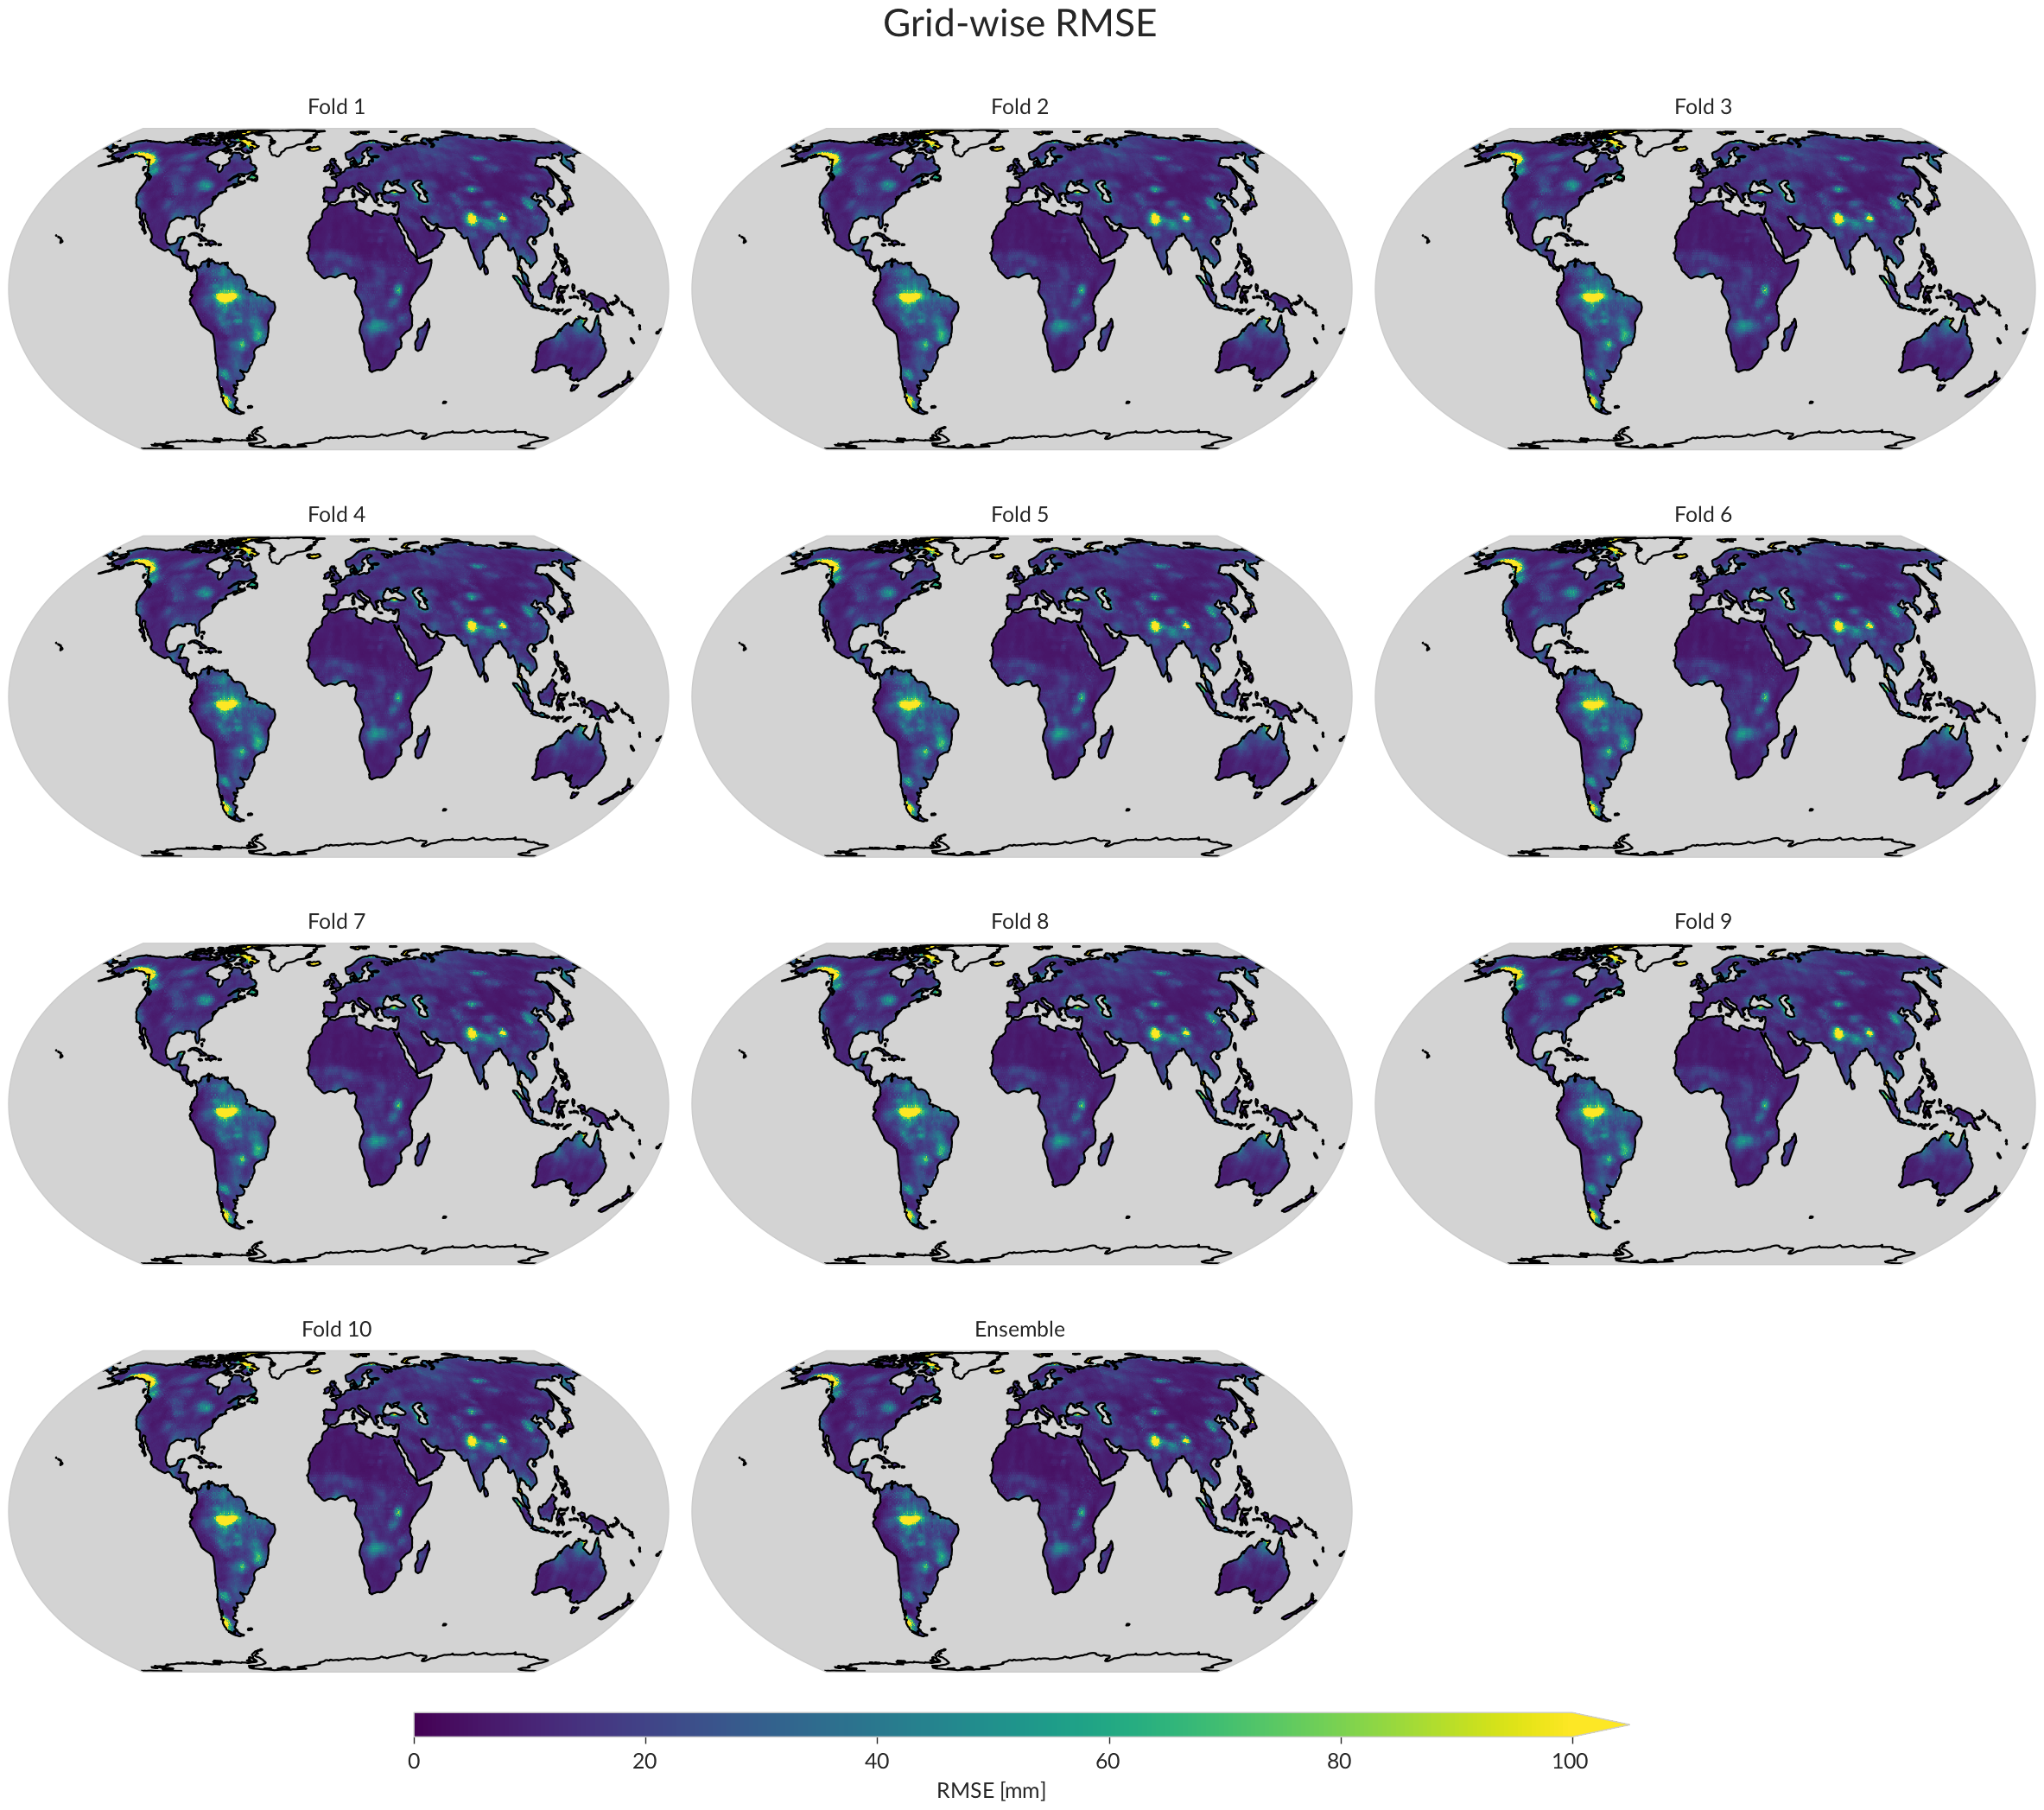

In [48]:
plot_kwargs = dict(
    vmin=0,
    vmax=100,
    col_wrap=3,
    coastlines=True,
    cmap="viridis",
    cbar_kwargs=dict(location="bottom", aspect=50, shrink=0.6, pad=0.02),
    figsize=(12, 12),
)
title_kwargs = dict(fontsize=16, weight="bold")

p = da_rmse.sel(model=fold_vars).dw.projplot(col="model", **plot_kwargs)

for ax, model in zip(p.axs.flat, fold_vars):
    ax.set_title(vars_verbose[model])
    ax.set_facecolor("lightgray")
p.fig.suptitle("Grid-wise RMSE", **title_kwargs);

### Basin-wise RMSE

Calculate the basin average time series:

In [49]:
# Dims: ("model", "region")
basin_avg = (
    # Basins over 200,000 km²
    mgd_nona.dw.select_basins(top=72).dw.weight_lat().mean(["lat", "lon"])
).compute()

[########################################] | 100% Completed | 118.23 s


In [50]:
preds_basin_rmse = metrics.rmse(basin_avg[target_var], basin_avg[eval_vars], dim="time")
da_basin_rmse = preds_basin_rmse.to_dataarray("model", name="rmse")
da_basin_rmse.attrs["standard_name"] = "RMSE"
da_basin_rmse.attrs["unit"] = "mm"

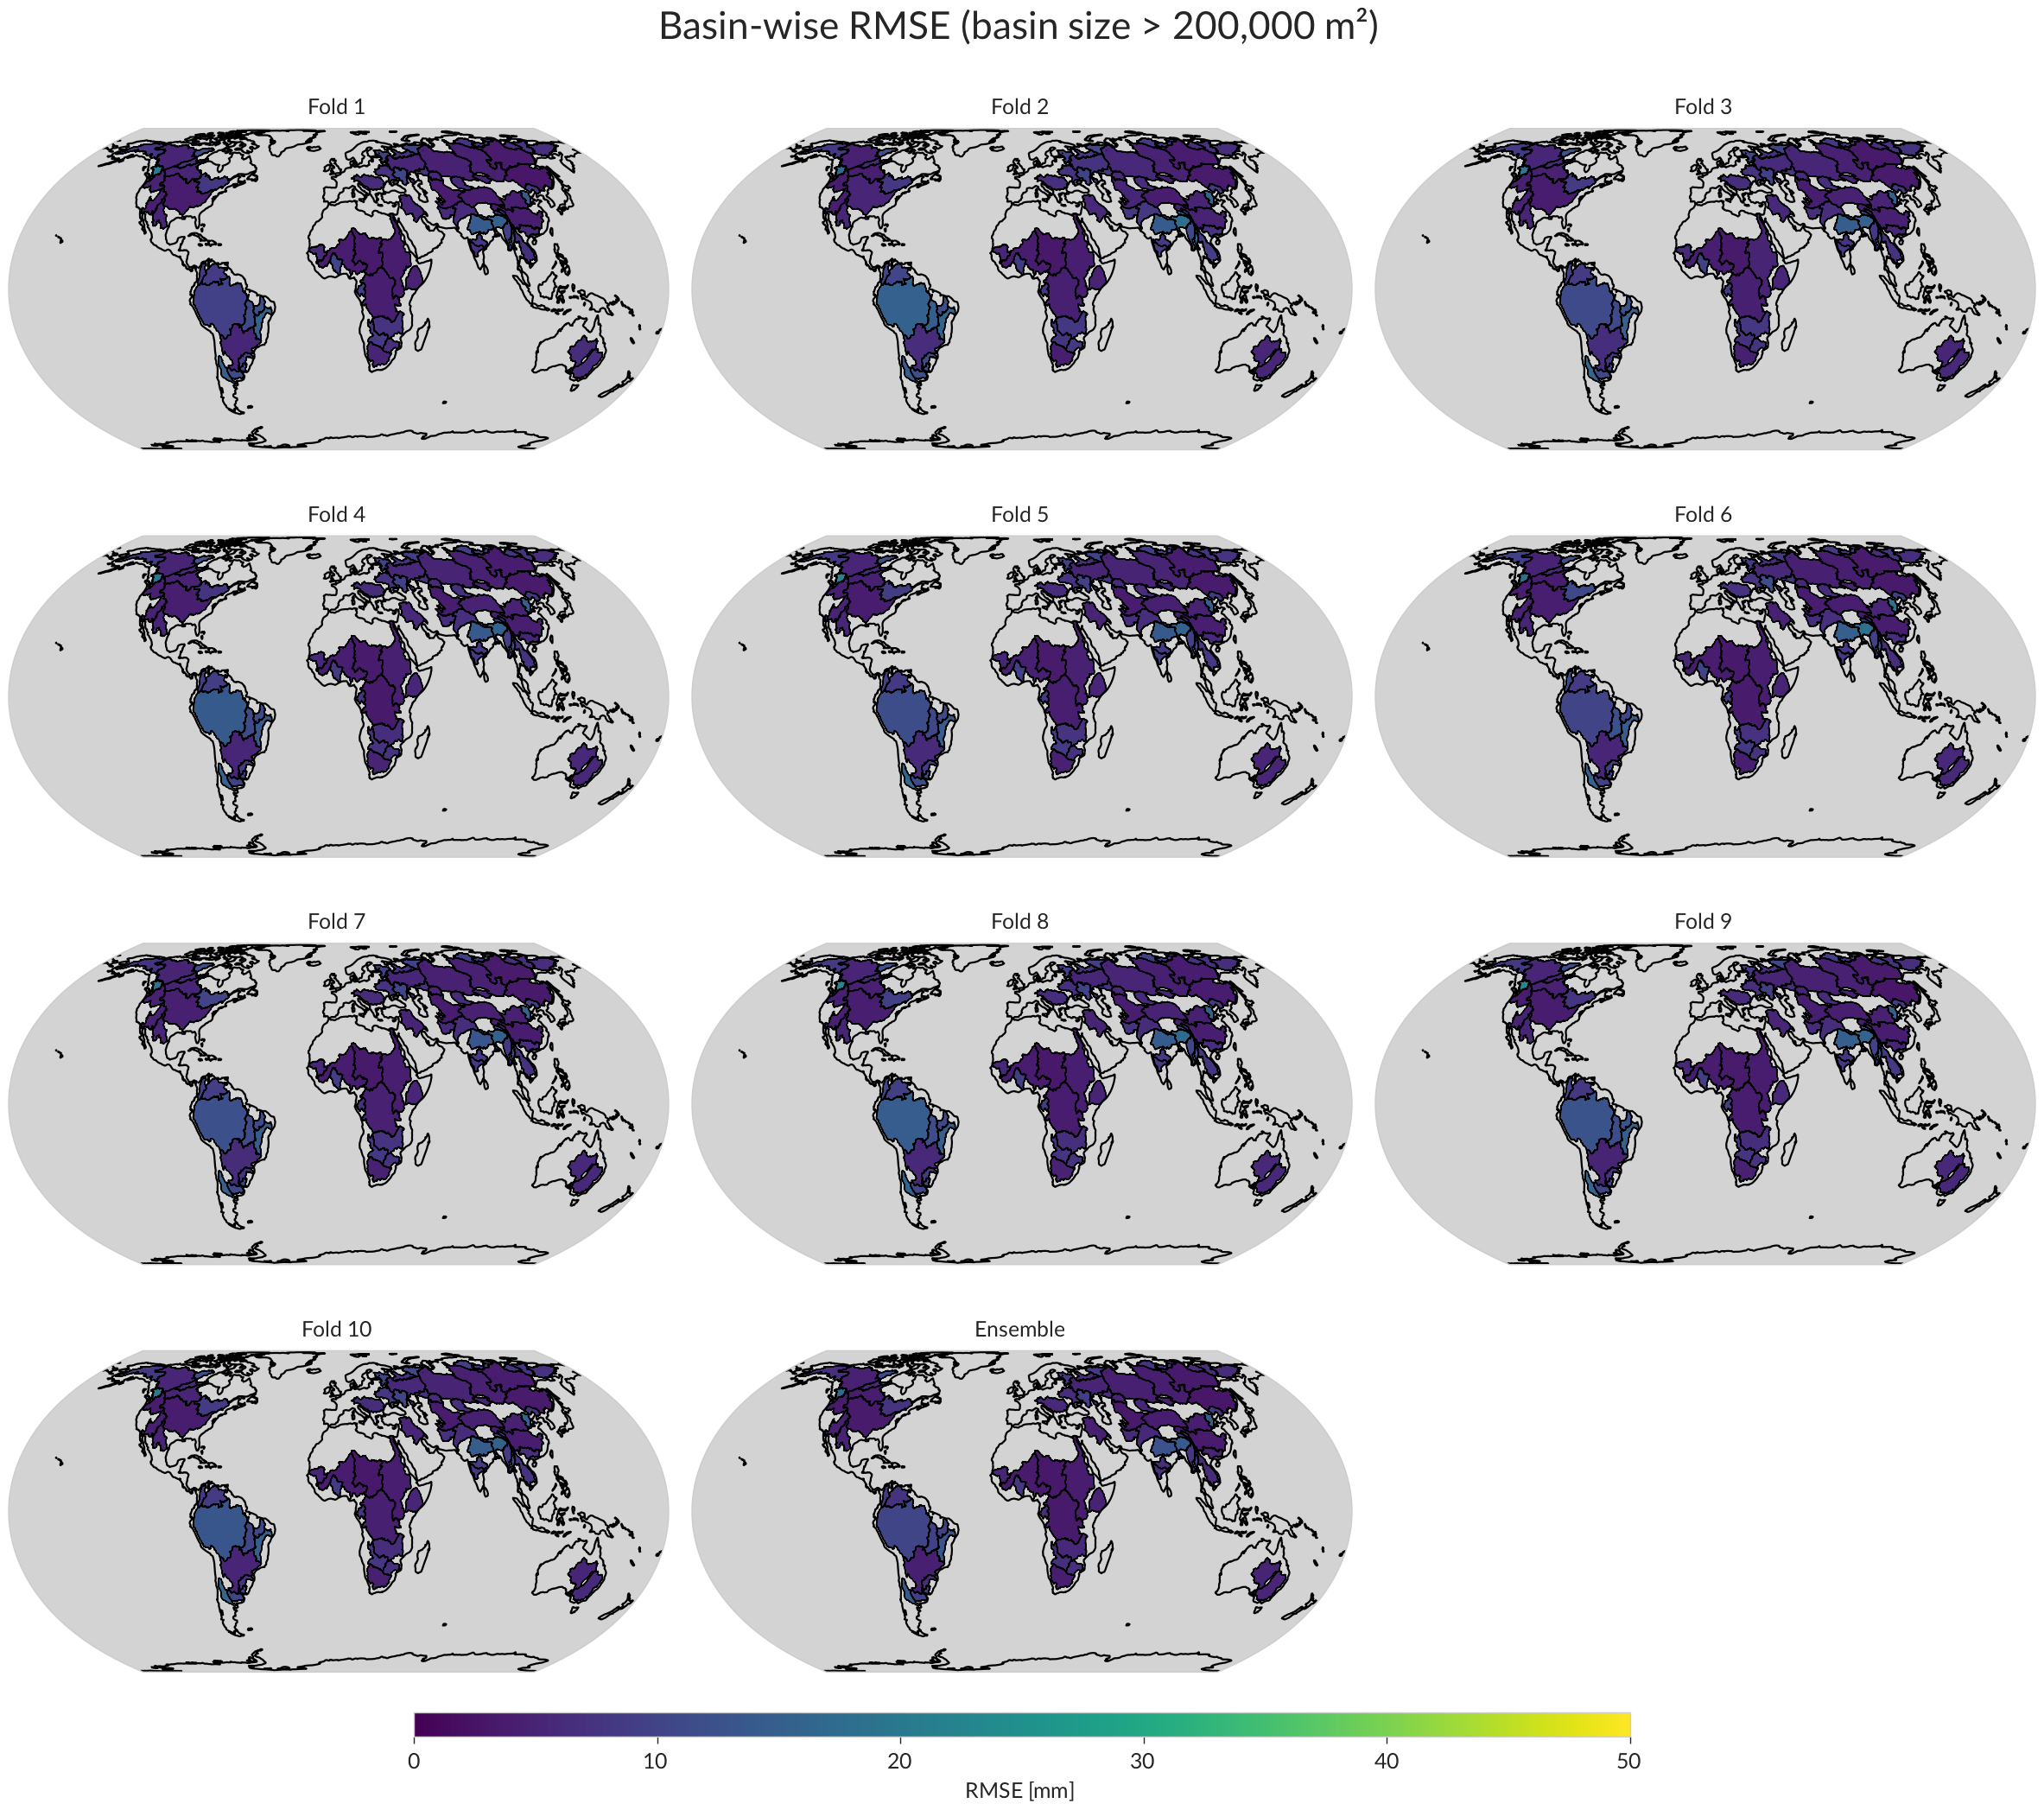

In [51]:
plot_kwargs["vmax"] = 50

p = plot_basinwise_map(
    da_basin_rmse.sel(model=fold_vars),
    da_rmse.sel(model=fold_vars),
    col="model",
    **plot_kwargs,
)

basin_shapes = basins(top=72)
for ax, model in zip(p.axs.flat, fold_vars):
    ax.set_title(vars_verbose[model])
    basin_shapes.dw.projplot(ax=ax, edgecolor="black", linewidth=0.5, facecolor="None")
    ax.set_facecolor("lightgray")
p.fig.suptitle("Basin-wise RMSE (basin size > 200,000 m²)", **title_kwargs);

## Averaged RMSE

Calculate the averaged grid-wise RMSE:

In [52]:
rmse_grid_avg = (
    da_rmse.dw.weight_lat().mean(["lat", "lon"]).rename("Grid-wise RMSE").compute()
)

Calculate the averaged basin-wise RMSE. We weigh each basin by the basin area:

In [53]:
basin_areas = basin_shapes.set_index(basin_shapes.river.rename("region")).shape_area
area_weights = xr.DataArray.from_series(basin_areas)

In [54]:
rmse_basin_avg = (
    da_basin_rmse.weighted(area_weights)
    .mean("region")
    .rename("Basin-wise RMSE")
    .compute()
)

In [55]:
table = (
    xr.merge([rmse_basin_avg, rmse_grid_avg])
    .to_pandas()
    .rename(vars_verbose)
    .sort_values(by="Basin-wise RMSE")
)
table

,Basin-wise RMSE,Grid-wise RMSE
model,,
Ensemble,5.533897,18.595713
Fold 1,6.033660,21.012479
Fold 6,6.125373,20.743095
Fold 9,6.236207,21.041821
Fold 7,6.315552,21.101938
Fold 4,6.387869,20.966931
Fold 5,6.392457,20.961859
Fold 10,6.404977,20.791811
Fold 3,6.413758,20.873028


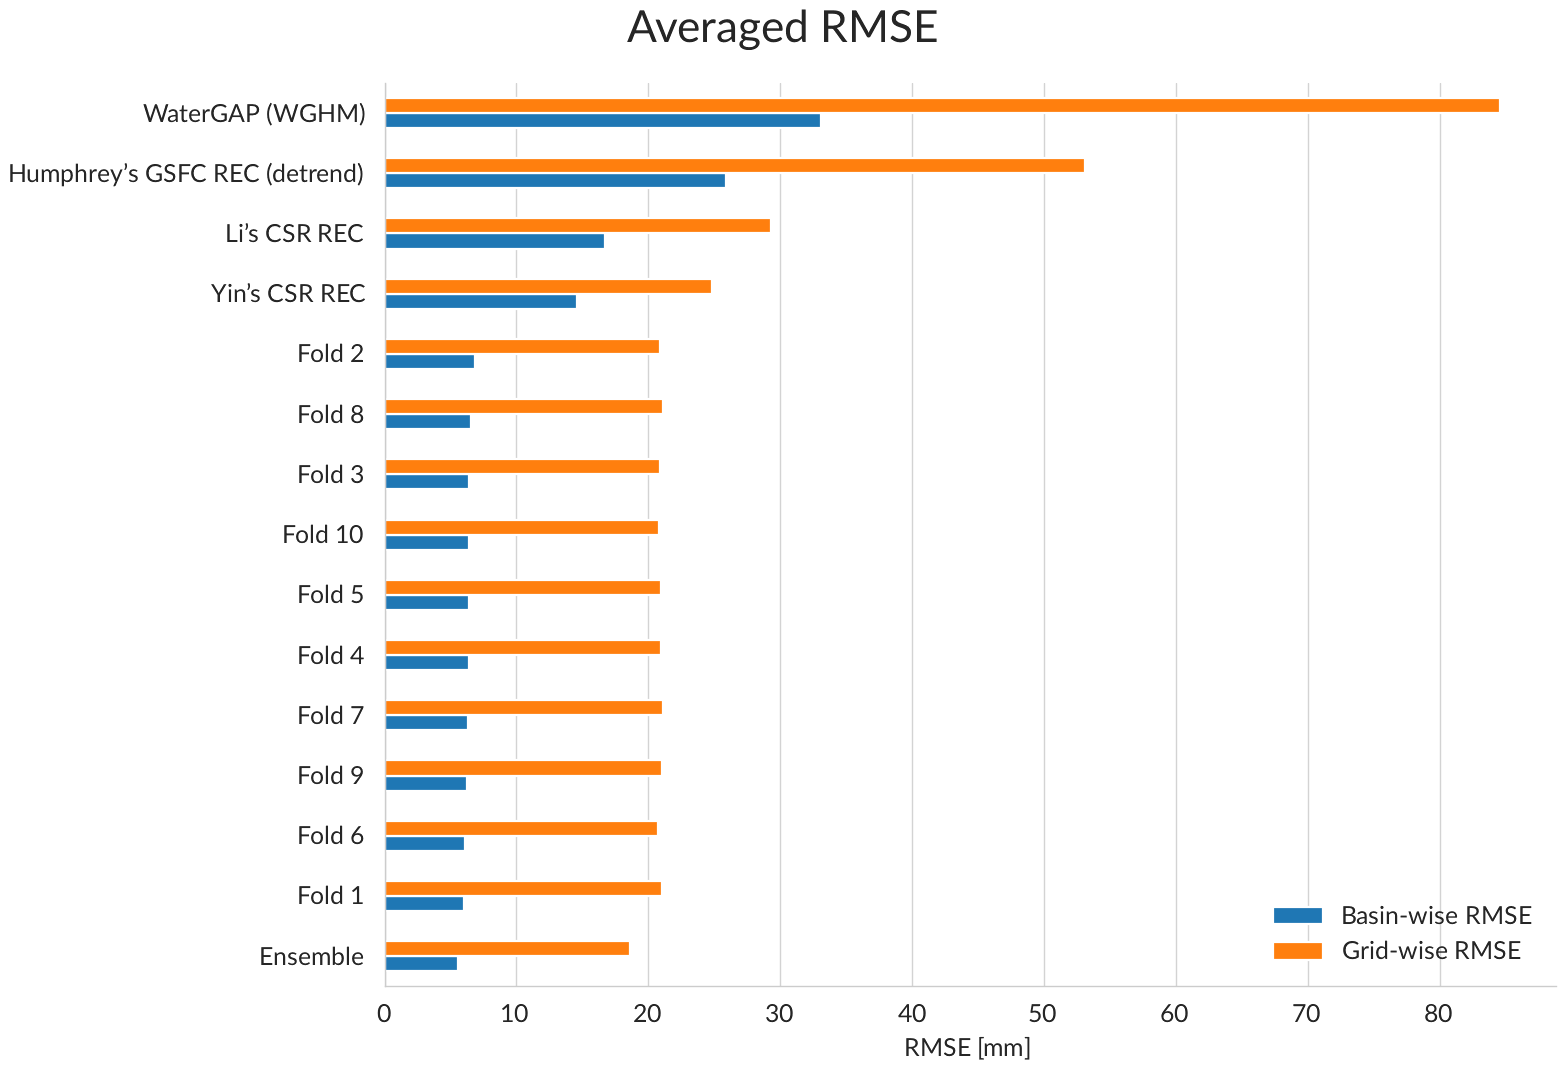

In [56]:
ax = table.plot.barh(figsize=(8, 5.5))
ax.yaxis.grid(False)
ax.set_xlabel("RMSE [mm]")
ax.set_ylabel(None)
ax.figure.suptitle("Averaged RMSE", **title_kwargs)
ax.legend(loc="lower right");